In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import os
import io
import requests
import numpy as np
import pandas as pd
import re
import zipfile
import random
import time
import csv
import datetime
from itertools import compress
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from torch import nn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
# from transformers import BertForSequenceClassification
from transformers import RobertaForSequenceClassification, RobertaTokenizer
# from transformers import BertForSequenceClassification, BertTokenizer
# from transformers import AutoTokenizer, AutoConfig, AutoModelForPreTraining, \
#                          AdamW, get_linear_schedule_with_warmup, \
#                          TrainingArguments, BeamScorer, Trainer

import torch
from torch.utils.data import Dataset, random_split, DataLoader, \
                             RandomSampler, SequentialSampler

from IPython.display import clear_output
from gensim.utils import tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import nltk
# from transformers import BertTokenizer




print(f"PyTorch version: {torch.__version__}")

PyTorch version: 1.11.0


In [3]:
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# model = RobertaForSequenceClassification.from_pretrained('roberta-base').cpu()


# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', max_length = 256)
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_length = 64)#, max_length = 256

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

In [4]:
def heavy_text_clean(x):
    # then use regex to remove @ symbols and hashtags
    x = re.sub(r'@\S', '', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', '', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)
    # remove single letters and numbers surrounded by space
    x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)
    return x

In [5]:
def remove_urls(vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)


# def 
def preprocessing(df):
    text_list = list(df['text'])
    preprocessed_texts = []
    for i in range(len(text_list)):
        text_tokenized = remove_urls(text_list[i])
#         text_tokenized = heavy_text_clean(text_tokenized)
        text_tokenized = list(tokenize(text_tokenized, lower = True, deacc = True))
#         preprocessed_texts.append(list(text_tokenized))
#         text_stemmed = [stemmer.stem(w) for w in text_tokenized if w not in stop_words]

#         text_without_stop_words = [w for w in text_stemmed if w not in stop_words]
#         text_without_stop_words = [w for w in text_stemmed if w not in stop_words]
#         preprocessed_texts.append(text_without_stop_words)
        preprocessed_texts.append(text_tokenized)
    
        
    for i in range(len(preprocessed_texts)):
        preprocessed_texts[i] = " ".join(preprocessed_texts[i])

    return preprocessed_texts  #возвращает корпус обработанных твитов



def model_vect_texts(df):
    vectorizer = TfidfVectorizer() #модель для векторизации текстов
    preprocessed_texts_for_train = preprocessing(df) #на каком корпусе текстов будем обучать vectorizer
    vectorizer.fit(preprocessed_texts_for_train) #обучаем vectorizer
    return vectorizer


def preprocessing_features(df, vectorizer):
    preprocessed_texts = preprocessing(df)

    tfidf = vectorizer.transform(preprocessed_texts)
#     df_tfidf = pd.DataFrame(tfidf.toarray(), columns = list(vectorizer.get_feature_names()))
#     df_tfidf['loc'] = df['location'] #их слишком много, они практичсеки эквивалентны 'id' как и keyword
#     df_tfidf = pd.get_dummies(df_tfidf)
    
    return tfidf

In [6]:
dataset_test_final = pd.read_csv("../input/nlp-getting-started/test.csv")
dataset_train = pd.read_csv("../input/nlp-getting-started/train.csv")
submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset_train, dataset_train['target'], random_state = 42, test_size=0.3)

In [8]:
dataset_train = list(zip(preprocessing(X_train), X_train['target'].ravel()))
dataset_test = list(zip(preprocessing(X_test), X_test['target'].ravel()))

In [9]:
# # dataset_train
# stop_words

In [10]:
def collate_fn(batch):
    texts = []
    targets = []
    for text, target in batch:
        targets.append(target)
        texts.append(text)
#     return tokenizer(texts, padding='max_length', return_tensors = 'pt', max_length = 364, truncation=True), torch.tensor(targets)
    return tokenizer(texts, return_tensors = 'pt', truncation=True, padding='max_length', max_length = 30), torch.tensor(targets)
train_dataloader = DataLoader(dataset_train, batch_size = 32, shuffle = False, collate_fn = collate_fn)
test_dataloader = DataLoader(dataset_test, batch_size = 32, shuffle = False, collate_fn = collate_fn)

In [11]:
for item in train_dataloader:
    print(item)
    break

({'input_ids': tensor([[    0, 14829, 28410,  7085,   493,  1717,  4056, 10278,    29,  6277,
            23,   326,  9854,  4081,   566,  2373,    11,   750, 20407,  1245,
         25862,    66, 28410,  7085,   493,    13,     2,     1,     1,     1],
        [    0, 12338,   475,  1725,  6703,  9205,  2205,   741,   821,  2446,
             7,   741, 20541,  3792, 18742,  1215, 49297,  4169,  1385,   282,
           910,   213, 22128, 22160, 38904,     2,     1,     1,     1,     1],
        [    0,   438, 15688,   326,  4734, 39941,  1569,  7364,  1094,  1985,
           848,    30,   249,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 17830, 13069,   154,    11,    10,   891,     9,   722,   314,
           454,   939,    33,     7,    28,    62,    13,  1380,     2,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    0,  8344,  2990,    

In [12]:
t = 0
ttt = []
for item in test_dataloader:
    t += 1


#     print(item)
#     print(type(item))
#     ttt.append()
    ttt.append(item[0]['input_ids'][0].detach().numpy().shape[0])
#     print(item[0]['input_ids'][0].detach().numpy().shape[0])
#     print(item[input_ids])
print(np.max(ttt))

30


In [13]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.bert = RobertaForSequenceClassification.from_pretrained('roberta-large')
#         self.bert = RobertaForSequenceClassification.from_pretrained('roberta-base')
#         self.linear = nn.Linear(768, 2)
# #                                                                     num_labels = 2,
# #                                                                     output_attentions = False,
# #                                                                     output_hidden_states = False)
#         self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased',
#                                                                     num_labels = 2,
#                                                                     output_attentions = False,
#                                                                     output_hidden_states = False)
        self.body = nn.Sequential(
            self.bert
        )
    def forward(self, input_ids, attention_mask):  
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits #неотмасштобированные вероятности, из них несложно получить вектор-распределение вероятностей
#     def forward(self, x: torch.Tensor):
#         return self.body(x)


# model = MyModel()
        
        



In [14]:
# from IPython.core.display import ProgressBar
# from tqdm.notebook import tqdm
# import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses_for_graph = []
train_f1_score_for_graph = []
test_losses_for_graph = []
test_f1_score_for_graph = []

def train_one_epoch(model, train_dataloader, criterion, optimizer, device = device):
    model.train().to(device)
    progress_bar = tqdm(train_dataloader, total = len(train_dataloader))
    losses = []
    f_1 = []
    f_1_targets_of_model = []
    f_1_targets_true = []
    for text, target in progress_bar:
        target = target.to(device)
        text = {k: v.to(device) for k, v in text.items()}
#         print(f'target = {target}')
        optimizer.zero_grad()
        res = model(**text) #возвращает уже логиты
        
        loss = criterion(res, target)
        
#         print(f'loss = {loss}')
#         print(f'res = {res}')
        losses.append(loss.item())
    


#         losses.append(loss.detach().numpy())
#         print(np.mean(losses))

    
#         print(f'targets now = {res.argmax(1)}')
#         f_1.append(f1_score((res.argmax(1))))
        f_1.append(f1_score((res.argmax(1)).to('cpu').detach().numpy(), target.to('cpu').detach().numpy()))
#         print(np.mean(f_1))
#         print(f_1)
        for i, j in list(zip(res.argmax(1).to('cpu').detach().numpy(), target.to('cpu').detach().numpy())):
            f_1_targets_of_model.append(i)
            f_1_targets_true.append(j)
            
        loss.backward()
        optimizer.step()
        progress_bar.set_description(f"Loss = {loss.item():.4f}")
    print(f'f_1 score on train:{np.mean(f_1)}, entropy:{np.mean(losses)}')
    print(f'f_1 score on all train: {f1_score(f_1_targets_of_model, f_1_targets_true)}')
    
    train_losses_for_graph.append(np.mean(losses))
    train_f1_score_for_graph.append(np.mean(f_1))
    
    
        
        


def evaluate(model, val_dataloader, criterion, device = device):
    model.eval().to(device)
    progress_bar = tqdm(val_dataloader)
    f_1 = []
    f_1_targets_of_model = []
    f_1_targets_true = []
    losses = []
  # model.eval().to(device)
    with torch.no_grad():
        for text, target in progress_bar:
            target = target.to(device)
            text = {k: v.to(device) for k, v in text.items()}
            res = model(**text) #возвращает уже логиты
            loss = criterion(res, target)
            losses.append(loss.item())
            
#             print(res.argmax(1).detach().numpy())
#             print(target.detach().numpy())
            f_1.append(f1_score((res.argmax(1)).to('cpu').detach().numpy(), target.to('cpu').detach().numpy()))
            for i, j in list(zip(res.argmax(1).to('cpu').detach().numpy(), target.to('cpu').detach().numpy())):
                f_1_targets_of_model.append(i)
                f_1_targets_true.append(j)
                
    
            # print(f_1)
            progress_bar.set_description(f"Loss = {loss.item():.4f}")
        print(f'f_1 score on test:{np.mean(f_1)}, entropy:{np.mean(losses)}')
        print(f'f_1 score on all test: {f1_score(f_1_targets_of_model, f_1_targets_true)}')
    
        test_losses_for_graph.append(np.mean(losses))
        test_f1_score_for_graph.append(np.mean(f_1))
#         test_f1_score_for_graph.append(np.mean(f_1))

    

def train(model, train_dataloader, val_dataloader, criterion, optimizer, n_epochs = 10, device = device):
    for epoch in range(n_epochs):
        
        
        train_one_epoch(model, train_dataloader, criterion, optimizer)
        evaluate(model, val_dataloader, criterion)
        
        
        
        
        
def stats_pd(train_losses_for_graph, test_losses_for_graph, train_f1_score_for_graph, test_f1_score_for_graph):
    df_stats = pd.DataFrame({'train loss': train_losses_for_graph,
                            'test_losses': test_losses_for_graph,
                            'train_f1': train_f1_score_for_graph,
                            'test_f1': test_f1_score_for_graph})
#     plt.figure(figsize=(15, 4))
# #     plt.title('{}'.format(title))
#     plt.plot(train_losses_for_graph, label='train_losses')
#     plt.plot(test_losses_for_graph, label='test_losses')
#     plt.plot(train_f1_score_for_graph, label='train_f1')
#     plt.plot(test_f1_score_for_graph, label='test_f1')
    
#     points = np.array(train_history)
#     plt.plot(points[:,0], points[:,1], label='train', zorder=1)
    
#     points = np.array(val_history)
    
#     plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
#     plt.xlabel('train steps')
    
#     plt.legend(loc='best')
#     plt.grid()

#     plt.show()
    return df_stats


In [15]:
from tqdm.autonotebook import tqdm
# model = RobertaForSequenceClassification.from_pretrained('roberta-base').cpu()
# device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', max_length = 256)


# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
# optimizer = torch.optim.RMSprop(model.parameters(), eps = 1, alpha = 0.8, lr = 2e-2)
criterion = nn.CrossEntropyLoss()




cuda


Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'clas

In [16]:
train(model, train_dataloader, test_dataloader, criterion, optimizer,
      n_epochs = 2)

  0%|          | 0/167 [00:00<?, ?it/s]

f_1 score on train:0.6631482948262188, entropy:0.48119282660013185
f_1 score on all train: 0.702085402184707


  0%|          | 0/72 [00:00<?, ?it/s]

f_1 score on test:0.8057819667631826, entropy:0.41421133817897904
f_1 score on all test: 0.8060637741766858


  0%|          | 0/167 [00:00<?, ?it/s]

f_1 score on train:0.8068670090520046, entropy:0.374358409357642
f_1 score on all train: 0.815906432748538


  0%|          | 0/72 [00:00<?, ?it/s]

f_1 score on test:0.7922420570821438, entropy:0.4145484310057428
f_1 score on all test: 0.7943971985992996


In [17]:
for param in model.parameters():
    param.requires_grad = False
    
    
to_freeze = [i for i, j in list(model.named_parameters())][-20 - 16*9:]#[-20:]
for name, param in model.named_parameters():
#     print(name)
    if name in to_freeze:
        param.requires_grad = True
for name, param in model.named_parameters():
#     print(name)
    if param.requires_grad == True:
        print(name)
        

bert.roberta.encoder.layer.14.attention.self.query.weight
bert.roberta.encoder.layer.14.attention.self.query.bias
bert.roberta.encoder.layer.14.attention.self.key.weight
bert.roberta.encoder.layer.14.attention.self.key.bias
bert.roberta.encoder.layer.14.attention.self.value.weight
bert.roberta.encoder.layer.14.attention.self.value.bias
bert.roberta.encoder.layer.14.attention.output.dense.weight
bert.roberta.encoder.layer.14.attention.output.dense.bias
bert.roberta.encoder.layer.14.attention.output.LayerNorm.weight
bert.roberta.encoder.layer.14.attention.output.LayerNorm.bias
bert.roberta.encoder.layer.14.intermediate.dense.weight
bert.roberta.encoder.layer.14.intermediate.dense.bias
bert.roberta.encoder.layer.14.output.dense.weight
bert.roberta.encoder.layer.14.output.dense.bias
bert.roberta.encoder.layer.14.output.LayerNorm.weight
bert.roberta.encoder.layer.14.output.LayerNorm.bias
bert.roberta.encoder.layer.15.attention.self.query.weight
bert.roberta.encoder.layer.15.attention.self.q

In [18]:
train(model, train_dataloader, test_dataloader, criterion, optimizer,
      n_epochs = 1)
stats = stats_pd(train_losses_for_graph, test_losses_for_graph, train_f1_score_for_graph, test_f1_score_for_graph)

  0%|          | 0/167 [00:00<?, ?it/s]

f_1 score on train:0.8449480321369026, entropy:0.3039517071611153
f_1 score on all train: 0.8521256931608133


  0%|          | 0/72 [00:00<?, ?it/s]

f_1 score on test:0.8026774129649493, entropy:0.4144409668321411
f_1 score on all test: 0.8027867095391211


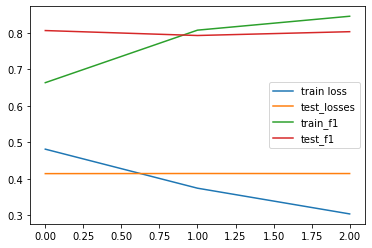

In [19]:
import matplotlib.pyplot as plt
stats.plot(kind = 'line', y=['train loss', 'test_losses', 'train_f1', 'test_f1'])
plt.show()

In [20]:
stats

,train loss,test_losses,train_f1,test_f1
0,0.481193,0.414211,0.663148,0.805782
1,0.374358,0.414548,0.806867,0.792242
2,0.303952,0.414441,0.844948,0.802677


In [21]:
# tokenizer(['its, it is you','hello, girl!', "This world be destroyed", 'What is the sense to cintinue living', 'I love you!', 'it is a wonderfull day', 'i will kill you'], padding = True, return_tensors = 'pt')
# print(**res)
# model(**res.to(device))

In [22]:
# dataset_submission = list((preprocessing(submission)))
# preprocessing(dataset_test_final)
# test_final_dataset

In [23]:

test_final_dataset = list((preprocessing(dataset_test_final)))
test_final_dataset_ready = tokenizer(test_final_dataset, padding='max_length', return_tensors = 'pt', max_length = 33, truncation=True)
ids = test_final_dataset_ready['input_ids'].to(device)
# print(ids.shape)
atm = test_final_dataset_ready['attention_mask'].to(device)
idsatm = list(zip(ids, atm))
idsatm_dataloader = DataLoader(idsatm, batch_size = 32, shuffle = False)
for item in idsatm_dataloader:
    print(item)
    break


[tensor([[    0,  8987,  1102,  ...,     1,     1,     1],
        [    0, 42225,    59,  ...,     1,     1,     1],
        [    0,  8585,    16,  ...,     1,     1,     1],
        ...,
        [    0,  7904,  8009,  ...,     1,     1,     1],
        [    0,  8987,   300,  ..., 16292,     2,     1],
        [    0,   118,  4157,  ...,     1,     1,     1]], device='cuda:0'), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')]


In [24]:
def evaluate_final(model, val_dataloader, criterion, device = device):
    model.eval().to(device)
    progress_bar = tqdm(val_dataloader)
    targets_final = []
    with torch.no_grad():
        for ids, ms in progress_bar:
            ids = ids.to(device)
            ms = ms.to(device)
            target_f = model(ids, ms).to('cpu').argmax(1).detach().numpy()
            for el in target_f:
                targets_final.append(el)
    return targets_final

In [25]:
answer_final = evaluate_final(model, idsatm_dataloader, criterion)


  0%|          | 0/102 [00:00<?, ?it/s]

In [26]:
submission["target"] = answer_final
submission.to_csv('mycsvfile_NLP_disaster_attempt2_13.csv', index=False)
# submission.to_csv('/Users/serafim/Desktop/Python/машинка/Kaggle_Natural Language Processing with Disaster Tweets/attempts/attempt2_1.csv', index=False)

In [27]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    5439 MB |    7088 MB |    4929 GB |    4923 GB |\n|       from large pool |    5432 MB |    7027 MB |    4898 GB |    4892 GB |\n|       from small pool |       6 MB |      80 MB |      31 GB |      31 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    5439 MB |    7088 MB |    4929 GB |    4923 GB |\n|       from large pool |    5432 MB |    7027 MB |